In [1]:
import sys
import pandas as pd
import numpy as np
import yaml
import seaborn as sns
from scipy.stats import truncnorm, rv_discrete

import math
from scipy.optimize import curve_fit

from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.distributions.mixture_rvs import mixture_rvs

sys.path.append("..")
from utility import utility as util

In [2]:
def read_yaml(file):
    with open(file, 'r') as yml_file:
        config = yaml.load(yml_file, Loader=yaml.FullLoader)
        return config

hour_dict = read_yaml(r'../num_ev_arrival_by_hour.yaml')

def poisson_dist_func(lam, k):
    return (pow(lam,k) * np.exp(-1*lam))/math.factorial(k)

def sample_num_EV_arrivals(rng, hour):

    hour_set=set(hour_dict[str(hour)])
    d={h:hour_dict[str(hour)].count(h) for h in hour_set}

    x_values = list(d.keys())
    y_values = list(d.values())/np.sum(list(d.values()))
            
    lam = np.sum(np.array(list(x_values)) * np.array(list(y_values))/np.sum(np.array(list(y_values))))
    
    pdf = []
    for k in x_values:
        pdf.append(poisson_dist_func(lam, k))
        
    probab = np.array(pdf)
    probab /= probab.sum()
    
    num_arrived_EVs = rng.choice(x_values, 1, p = probab)
      
    return num_arrived_EVs[0]  


#stay_time_dict = read_yaml(r'J:\Thesis_code\thesis_code_saidur\Thesis_Code_LATEST_ONLY\EV\ev_stay_t_by_arrival_hour.yaml')
stay_time_dict = read_yaml(r'../ev_stay_t_by_arrival_hour.yaml')


#============ This function samples the EV stay time using Kernel Density Estimation ============ 

def sample_ev_stay_time(rng, hour):

    kde = sm.nonparametric.KDEUnivariate(stay_time_dict[str(hour)])
    kde.fit()

    x_vals = kde.support
    pdf = kde.density/np.sum(kde.density)

    ev_stay_time = (int(np.around(np.abs(rng.choice(x_vals, 1, p = pdf)))[0]))

    return ev_stay_time 
    #return ev_stay_time, kde.support, kde.density # For plottin
	
	
#data_config = read_yaml(r'J:\Thesis_code\thesis_code_saidur\Thesis_Code_LATEST_ONLY\config\data_config.yml')
data_config = read_yaml(r'../config/data_config.yml')

def get_truncated_normal(mean, sd, low, upp):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def sample_init_soc(seed):
    np.random.seed(seed)
    battery_specs = data_config['sessions_processing']['battery_start']
    init_soc = get_truncated_normal(battery_specs['mean'], battery_specs['scale'],
                                                        battery_specs['lower_bound'],
                                                        battery_specs['upper_bound']).rvs()

    return init_soc
def create_ev_dict(seed):
    rng = np.random.default_rng(seed)

    FINAL_SOC = 0.97
    ALPHA_C = 11
    B_CAP = 80
    ETA_C = 0.98

    ev_dict = {}
    ev_outer_keys = ['init_soc','ev_stay_t','ev_laxity']

    for key in ev_outer_keys:
        ev_dict[key] = {}

    for key in ev_outer_keys:
        for h in range(24):
            ev_dict[key]['hour_{}'.format(str(h))] = []
                 
    for hour in range(24):
        num_arrived_ev = sample_num_EV_arrivals(rng, hour)

        for _ in range(num_arrived_ev):
            stay_t = sample_ev_stay_time(rng, hour)
            init_soc = sample_init_soc(seed)
            seed += 1
            depart_time = hour + stay_t
            if(depart_time > 23):
                depart_time = 23
                stay_t = depart_time - hour
            laxity = stay_t - (FINAL_SOC - init_soc)*B_CAP/(ALPHA_C * ETA_C)
            if(laxity >= 0):
                ev_dict['ev_stay_t']['hour_{}'.format(hour)].append(stay_t)
                ev_dict['init_soc']['hour_{}'.format(hour)].append(init_soc)
                ev_dict['ev_laxity']['hour_{}'.format(hour)].append(laxity)
                
    return ev_dict


In [3]:
E_im_price = util.load_result(r'../new_expected_values/E_price_imbalance')
print(E_im_price)
print(len(E_im_price))
print(np.mean(E_im_price))

[0.03955463 0.0405946  0.03779252 0.03764846 0.03552888 0.03545673
 0.04048251 0.05021839 0.06514552 0.05959292 0.05181795 0.04809238
 0.05255309 0.04415357 0.04318994 0.04092699 0.04027669 0.05650751
 0.05835924 0.05899516 0.06029614 0.05233466 0.04713364 0.04459264]
24
0.04755186394392306


In [4]:
df_price_2 = pd.read_csv('../real_data/2019_test_data_price.csv')
df_price_2.describe()

,price_da,price_imbalance,Hour
count,8760.000000,8760.000000,8760.000000
mean,0.041197,0.041140,11.500000
std,0.011278,0.034948,6.922582
min,-0.009020,-0.148163,0.000000
25%,0.034100,0.025489,5.750000
50%,0.039700,0.032848,11.500000
75%,0.047393,0.045947,17.250000
max,0.121460,0.460695,23.000000


In [5]:
df_price = pd.read_csv('../sampling_price_data.csv')
#df_price["date"] = pd.to_datetime(df_price["Date"])
#df_price["hour"] = df_price["date"].dt.hour
#df_price["price_imbalance"] = df_price["price_imbalance"] / 1000
display(df_price[["price_imbalance", "Hour"]].describe())
gdf_price = df_price.groupby("Hour").agg(price_imbalance = ("price_imbalance", "mean")).reset_index()
gdf_price.head(50)

,price_imbalance,Hour
count,32880.000000,32880.000000
mean,0.047552,11.500000
std,0.053456,6.922292
min,-0.414170,0.000000
25%,0.023190,5.750000
50%,0.037283,11.500000
75%,0.059684,17.250000
max,0.717250,23.000000


,Hour,price_imbalance
0,0,0.039555
1,1,0.040595
2,2,0.037793
3,3,0.037648
4,4,0.035529
5,5,0.035457
6,6,0.040483
7,7,0.050218
8,8,0.065146
9,9,0.059593


In [6]:
df_price = pd.read_csv('../price_data_saidur.csv')
df_price["date"] = pd.to_datetime(df_price["date"])
df_price["hour"] = df_price["date"].dt.hour
df_price["price_imbalance"] = df_price["price_imbalance"] / 1000
df_price["price_da"] = df_price["price_da"] / 1000
display(df_price[["price_da", "price_imbalance", "hour"]].describe())
gdf_price = df_price.groupby("hour").agg(price_imbalance = ("price_imbalance", "mean")).reset_index()
gdf_price.head(50)

,price_da,price_imbalance,hour
count,26280.000000,26280.000000,26280.000000
mean,0.041975,0.042006,11.500000
std,0.016341,0.043513,6.922318
min,-0.079190,-0.341427,0.000000
25%,0.031990,0.021892,5.750000
50%,0.040450,0.034201,11.500000
75%,0.050893,0.050793,17.250000
max,0.200040,0.717250,23.000000


,hour,price_imbalance
0,0,0.034873
1,1,0.036028
2,2,0.033717
3,3,0.032703
4,4,0.030026
5,5,0.030415
6,6,0.034442
7,7,0.042712
8,8,0.057205
9,9,0.053834


In [7]:
mean_hours = []
weight_hours = []
for i in range(24):
    hours = stay_time_dict[str(i)]
    mean_hours.append(np.mean(hours))
    weight_hours.append(len(hours))
    print(f"{i}: {np.mean(hours)=:.2f}, {np.std(hours)=:.2f}, {len(hours)=}")
print(np.average(mean_hours, weights = weight_hours))

0: np.mean(hours)=11.00, np.std(hours)=4.74, len(hours)=9
1: np.mean(hours)=8.67, np.std(hours)=4.37, len(hours)=12
2: np.mean(hours)=7.29, np.std(hours)=3.92, len(hours)=7
3: np.mean(hours)=11.33, np.std(hours)=3.40, len(hours)=3
4: np.mean(hours)=6.40, np.std(hours)=3.41, len(hours)=10
5: np.mean(hours)=7.05, np.std(hours)=3.49, len(hours)=131
6: np.mean(hours)=6.60, np.std(hours)=3.22, len(hours)=460
7: np.mean(hours)=5.73, np.std(hours)=3.24, len(hours)=787
8: np.mean(hours)=4.74, np.std(hours)=2.93, len(hours)=772
9: np.mean(hours)=3.79, np.std(hours)=2.91, len(hours)=551
10: np.mean(hours)=3.29, np.std(hours)=2.97, len(hours)=662
11: np.mean(hours)=3.79, np.std(hours)=3.92, len(hours)=654
12: np.mean(hours)=3.42, np.std(hours)=3.54, len(hours)=700
13: np.mean(hours)=3.88, np.std(hours)=4.52, len(hours)=625
14: np.mean(hours)=4.38, np.std(hours)=5.09, len(hours)=605
15: np.mean(hours)=6.15, np.std(hours)=6.33, len(hours)=654
16: np.mean(hours)=7.09, np.std(hours)=6.40, len(hours)=

### Num arrivals

In [8]:
rng = np.random.default_rng()
num_arrivals = 0
n_days = 100
for i in range(n_days):
    for j in range(24):
        num_arrivals += sample_num_EV_arrivals(rng, j)
print(f"Arrivals per day {num_arrivals/n_days:.4f}")
        

Arrivals per day 28.1300


### Stay time

	     mean 	 min 	 p25 	 p50 	 p75 	 max 
Stay_values: 5.63,	 0,	 2.00,	 4.00,	 9.0,	 22
isoc_values: 0.50,	 0.26,	 0.40,	 0.50,	 0.60,	 0.73


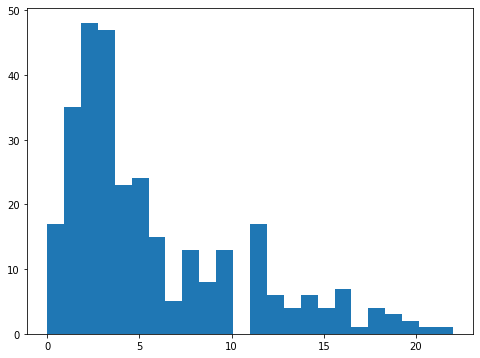

In [9]:
stay_values = []
initsoc_values = []

rng = np.random.default_rng()
for i in range(10):
    for j in range(24):
        num_arr = sample_num_EV_arrivals(rng, j)
        #print(j, num_arr)
        for k in range(num_arr):
            stay_values.append(sample_ev_stay_time(rng, j))
            seed = int(rng.uniform(0, 10000))
            initsoc_values.append(sample_init_soc(seed))

fig1 = plt.figure(figsize = (8,6))
ax1 = fig1.add_subplot(1,1,1)
ax1.hist(stay_values, bins = 24)
print(f"\t     mean \t min \t p25 \t p50 \t p75 \t max ")
print(f"""Stay_values: {np.mean(stay_values):.2f},\t {min(stay_values)},\t {np.percentile(stay_values, 25):.2f},\t {np.median(stay_values):.2f},\t {np.percentile(stay_values, 75)},\t {max(stay_values)}""")
print(f"""isoc_values: {np.mean(initsoc_values):.2f},\t {min(initsoc_values):.2f},\t {np.percentile(initsoc_values, 25):.2f},\t {np.median(initsoc_values):.2f},\t {np.percentile(initsoc_values, 75):.2f},\t {max(initsoc_values):.2f}""")

In [10]:
ev_dict = util.load_result('../w_mc_results/ev_dict')
seed = 1

In [11]:
seed += 1
create_ev_dict(seed)['ev_stay_t']

{'hour_0': [],
 'hour_1': [],
 'hour_2': [],
 'hour_3': [],
 'hour_4': [],
 'hour_5': [],
 'hour_6': [],
 'hour_7': [7],
 'hour_8': [2],
 'hour_9': [3],
 'hour_10': [4],
 'hour_11': [5, 8],
 'hour_12': [],
 'hour_13': [4, 6],
 'hour_14': [],
 'hour_15': [8, 3],
 'hour_16': [6, 7, 4, 7],
 'hour_17': [5],
 'hour_18': [],
 'hour_19': [],
 'hour_20': [3],
 'hour_21': [],
 'hour_22': [],
 'hour_23': []}

In [12]:
print(f"{len(hour_dict)=}")
print(f"{len(hour_dict['0'])=}")

len(hour_dict)=24
len(hour_dict['0'])=359


In [13]:
num_arrivals = 0
for i in range(len(hour_dict)):
    num_arrivals += np.sum(hour_dict[str(i)])
num_arrivals / 359

27.832869080779943

# Expected price

In [14]:
E_im_price = util.load_result(r'../new_expected_values/E_price_imbalance')
E_im_price

array([0.03955463, 0.0405946 , 0.03779252, 0.03764846, 0.03552888,
       0.03545673, 0.04048251, 0.05021839, 0.06514552, 0.05959292,
       0.05181795, 0.04809238, 0.05255309, 0.04415357, 0.04318994,
       0.04092699, 0.04027669, 0.05650751, 0.05835924, 0.05899516,
       0.06029614, 0.05233466, 0.04713364, 0.04459264])

In [15]:
df_price.describe(datetime_is_numeric = True)

,date,price_da,key,minutes,price_imbalance,regulation_state,mid_price,hour
count,26280,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000
mean,2019-07-02 11:30:00,0.041975,4.000685,90.020548,0.042006,0.690145,31.531498,11.500000
min,2018-01-01 00:00:00,-0.079190,0.000000,0.000000,-0.341427,-8.000000,0.000000,0.000000
25%,2018-10-01 17:45:00,0.031990,4.000000,90.000000,0.021892,-2.000000,23.016875,5.750000
50%,2019-07-02 11:30:00,0.040450,4.000000,90.000000,0.034201,1.000000,31.272500,11.500000
75%,2020-04-01 05:15:00,0.050893,4.000000,90.000000,0.050793,3.000000,39.590625,17.250000
max,2020-12-30 23:00:00,0.200040,14.000000,360.000000,0.717250,8.000000,107.380000,23.000000
std,NaN,0.016341,0.116062,3.040807,0.043513,2.816954,11.310907,6.922318


In [16]:
display(df_price[df_price.date.dt.year == 2018].groupby(by = ["hour"]).agg(E_imbalance = ("price_imbalance", "mean")).reset_index().head())
display(df_price[df_price.date.dt.year == 2019].groupby(by = ["hour"]).agg(E_imbalance = ("price_imbalance", "mean")).reset_index().head())
display(df_price[df_price.date.dt.year == 2020].groupby(by = ["hour"]).agg(E_imbalance = ("price_imbalance", "mean")).reset_index().head())

,hour,E_imbalance
0,0,0.040759
1,1,0.042804
2,2,0.038901
3,3,0.040247
4,4,0.037985


,hour,E_imbalance
0,0,0.035940
1,1,0.036384
2,2,0.034213
3,3,0.034001
4,4,0.031225


,hour,E_imbalance
0,0,0.027921
1,1,0.028896
2,2,0.028036
3,3,0.023860
4,4,0.020868


## Boxplot prices

In [17]:
df_price[df_price["date"].dt.year == 2019].describe()

,price_da,key,minutes,price_imbalance,regulation_state,mid_price,hour
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,0.041200,4.000685,90.020548,0.041141,0.893607,30.480858,11.500000
std,0.011296,0.116066,3.040922,0.034951,2.778024,7.646210,6.922582
min,-0.009020,0.000000,0.000000,-0.148163,-4.000000,0.000000,0.000000
25%,0.034100,4.000000,90.000000,0.025489,-1.000000,25.732500,5.750000
50%,0.039700,4.000000,90.000000,0.032852,1.000000,29.530000,11.500000
75%,0.047400,4.000000,90.000000,0.045961,3.000000,34.913125,17.250000
max,0.121460,14.000000,360.000000,0.460695,8.000000,107.380000,23.000000


In [18]:
df_price_2019 = df_price[df_price["date"].dt.year == 2019].copy()
df_im_2019 = df_price_2019[["date", "hour", "price_imbalance"]].rename(columns = {"price_imbalance": "price"})
df_im_2019["type"] = "Price Imbalance"
df_da_2019 = df_price_2019[["date", "hour", "price_da"]].rename(columns = {"price_da": "price"})
df_da_2019["type"] = "Price Day-Ahead"
df_box_2019 = pd.concat((df_im_2019, df_da_2019)).sort_values(by = ["date", "type"]).reset_index(drop = True)
df_box_2019["price"] = np.maximum(0, df_box_2019["price"])

# Sanity check
print(f"{len(df_price_2019)=}")
print(f"{len(df_im_2019)=}")
print(f"{len(df_da_2019)=}")
print(f"{len(df_box_2019)=}")
df_box_2019.head()

len(df_price_2019)=8760
len(df_im_2019)=8760
len(df_da_2019)=8760
len(df_box_2019)=17520


,date,hour,price,type
0,2019-01-01 00:00:00,0,0.068920,Price Day-Ahead
1,2019-01-01 00:00:00,0,0.044195,Price Imbalance
2,2019-01-01 01:00:00,1,0.064980,Price Day-Ahead
3,2019-01-01 01:00:00,1,0.039895,Price Imbalance
4,2019-01-01 02:00:00,2,0.060270,Price Day-Ahead


In [20]:
import matplotlib as mpl
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

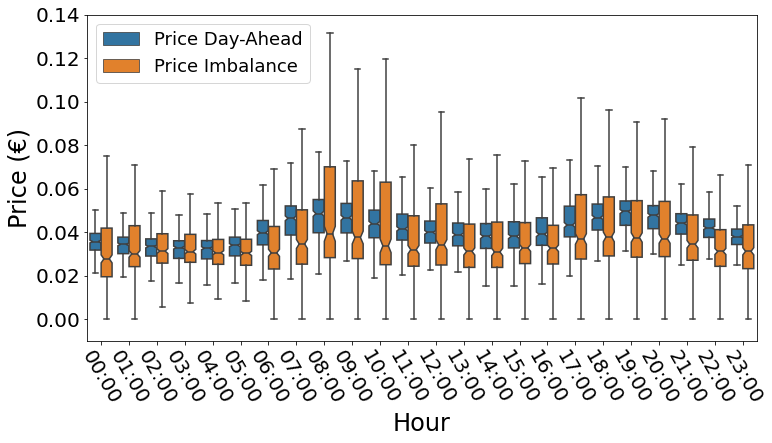

In [21]:
fig1 = plt.figure(figsize = (12,6))
ax1 = fig1.add_subplot(1,1,1)

sns.boxplot(data=df_box_2019, y="price", x= "hour", notch=True, hue = "type", ax = ax1, fliersize = 0, orient = "v")
ax1.set_ylim([-0.01, 0.13])
ax1.set_ylabel("Price (€)", fontsize = 24)
ax1.set_xlabel("Hour", fontsize = 24)
x_ticks = ax1.get_xticks()
ax1.set_xticks(x_ticks)
# Set xticks labels to hour format
x_ticklabels = [f"{int(x):02d}:00" for x in x_ticks]
ax1.set_xticklabels(x_ticklabels, fontsize = 20, rotation = -60, ha = "center")
y_ticks = ax1.get_yticks()[1:]
ax1.set_yticks(y_ticks)
y_ticklabels = [f"{y:.2f}" for y in y_ticks]
ax1.set_yticklabels(y_ticklabels, fontsize = 20)
legend = ax1.get_legend()
legend.set_title("")
ax1.legend(fontsize = 18)

fig1.savefig("/home/javier/Documents/Escuela/SCRG/Refs/Contracts/Figs/fig_hourlyDistr.pdf", dpi = 600, bbox_inches='tight')

In [18]:
x_ticklabels

['00:00',
 '01:00',
 '02:00',
 '03:00',
 '04:00',
 '05:00',
 '06:00',
 '07:00',
 '08:00',
 '09:00',
 '10:00',
 '11:00',
 '12:00',
 '13:00',
 '14:00',
 '15:00',
 '16:00',
 '17:00',
 '18:00',
 '19:00',
 '20:00',
 '21:00',
 '22:00',
 '23:00']